In [1]:
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

Using TensorFlow backend.


### Utility functions 


In [2]:
def plot_autoencoder_outputs(autoencoder, n, dims):
    decoded_imgs = autoencoder.predict(x_test)

    # number of example digits to show
    n = 5
    plt.figure(figsize=(10, 4.5))
    for i in range(n):
        # plot original image
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Original Images')

        # plot reconstruction 
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(*dims))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if i == n/2:
            ax.set_title('Reconstructed Images')
    plt.show()

In [3]:
def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    

In [4]:
def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()

Load data

We will use the popular MNIST dataset as input. It contains black-and-white images of handwritten digits. They’re of size 28x28 and we use them as a vector of 784 numbers between [0, 1].

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


Build model

We will now implement the autoencoder with Keras. The hyperparameters are: 128 nodes in the hidden layer, code size is 32, and binary crossentropy is the loss function.

In [6]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

W0827 18:56:26.660855 140226246170368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:68: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0827 18:56:26.676129 140226246170368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:507: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 18:56:26.679584 140226246170368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3831: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [7]:
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
autoencoder.fit(x_train, x_train, epochs=20)

W0827 18:56:26.734130 140226246170368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:757: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0827 18:56:26.870626 140226246170368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:976: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0827 18:56:26.979512 140226246170368 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:963: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
60000/60000 [==============================] - 8s 129us/step - loss: 0.0253 - acc: 0.0107
Epoch 2/20
60000/60000 [==============================] - 7s 116us/step - loss: 0.0133 - acc: 0.0115
Epoch 3/20
60000/60000 [==============================] - 7s 117us/step - loss: 0.0118 - acc: 0.0122
Epoch 4/20
60000/60000 [==============================] - 7s 116us/step - loss: 0.0108 - acc: 0.0123
Epoch 5/20
60000/60000 [==============================] - 7s 117us/step - loss: 0.0100 - acc: 0.0129
Epoch 6/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.0093 - acc: 0.0122
Epoch 7/20
60000/60000 [==============================] - 7s 117us/step - loss: 0.0088 - acc: 0.0126
Epoch 8/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.0084 - acc: 0.0128
Epoch 9/20
60000/60000 [==============================] - 7s 113us/step - loss: 0.0081 - acc: 0.0127
Epoch 10/20
60000/60000 [==============================] - 7s 115us/step - loss: 0.0079 - a

For every image in the test set, we get the output of the autoencoder. We expect the output to be very similar to the input.

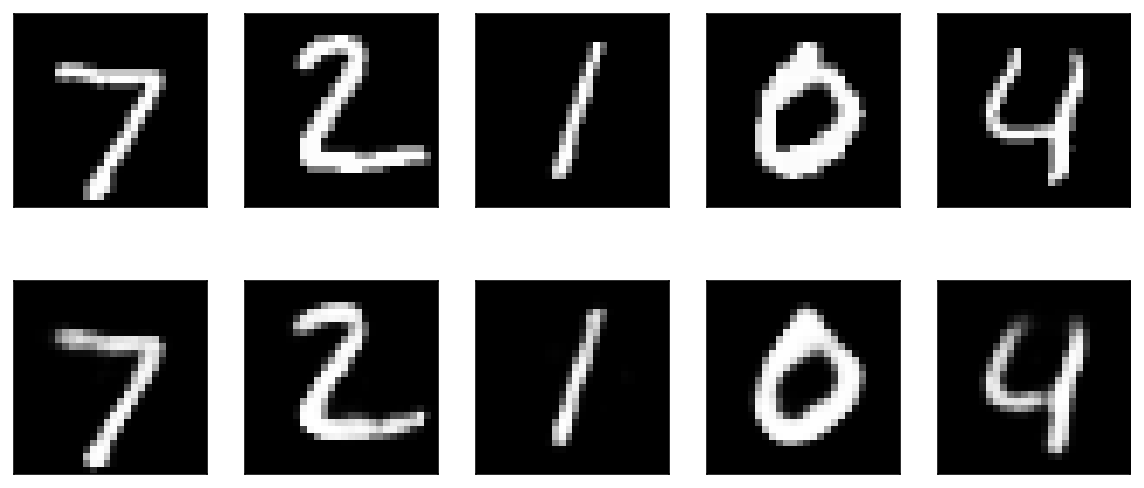

In [8]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))


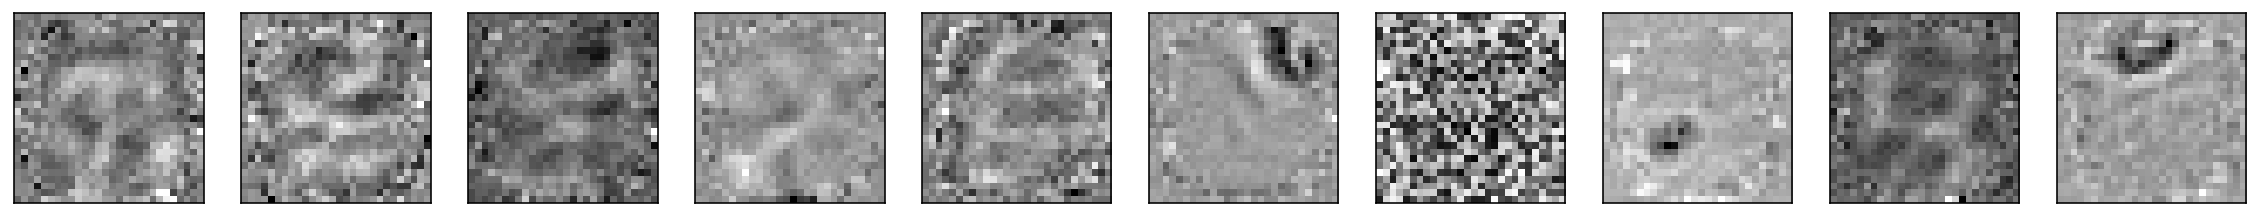

In [9]:
weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+0].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [10]:
autoencoder.get_weights()[0].shape

(784, 128)

### Shallow Autoencoder 

In [11]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size, ))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam',
                    loss='mean_squared_error',
                    metrics=['accuracy'])
autoencoder.fit(x_train, x_train, epochs=20)

Epoch 1/20
60000/60000 [==============================] - 6s 92us/step - loss: 0.0319 - acc: 0.0105
Epoch 2/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.0133 - acc: 0.0121
Epoch 3/20
60000/60000 [==============================] - 5s 87us/step - loss: 0.0110 - acc: 0.0109
Epoch 4/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.0106 - acc: 0.0109
Epoch 5/20
60000/60000 [==============================] - 5s 89us/step - loss: 0.0105 - acc: 0.0108
Epoch 6/20
60000/60000 [==============================] - 5s 87us/step - loss: 0.0104 - acc: 0.0107
Epoch 7/20
60000/60000 [==============================] - 5s 88us/step - loss: 0.0103 - acc: 0.0115
Epoch 8/20
60000/60000 [==============================] - 5s 87us/step - loss: 0.0103 - acc: 0.0113
Epoch 9/20
60000/60000 [==============================] - 5s 84us/step - loss: 0.0102 - acc: 0.0112
Epoch 10/20
60000/60000 [==============================] - 5s 87us/step - loss: 0.0102 - acc: 0.0111

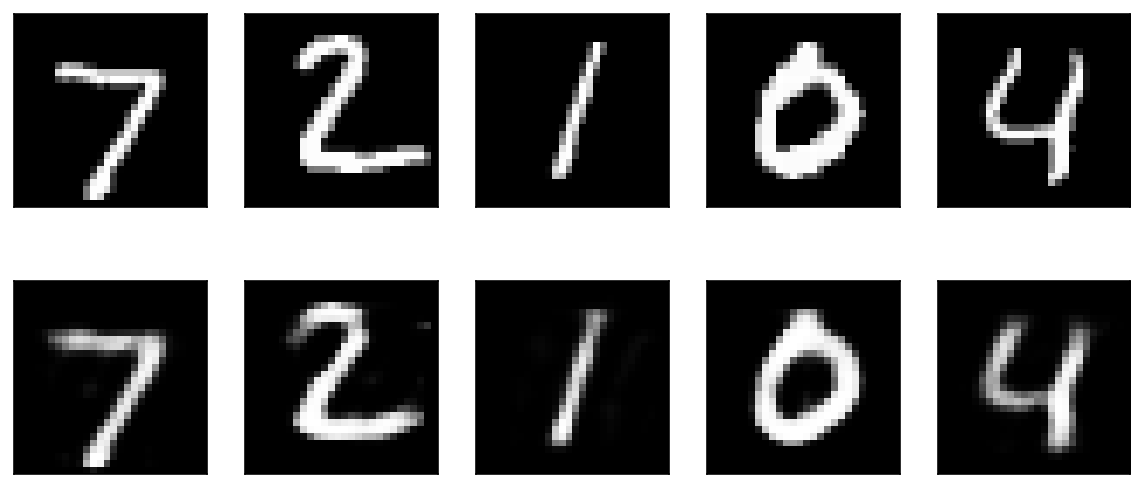

In [12]:
plot_autoencoder_outputs(autoencoder, 5, (28, 28))


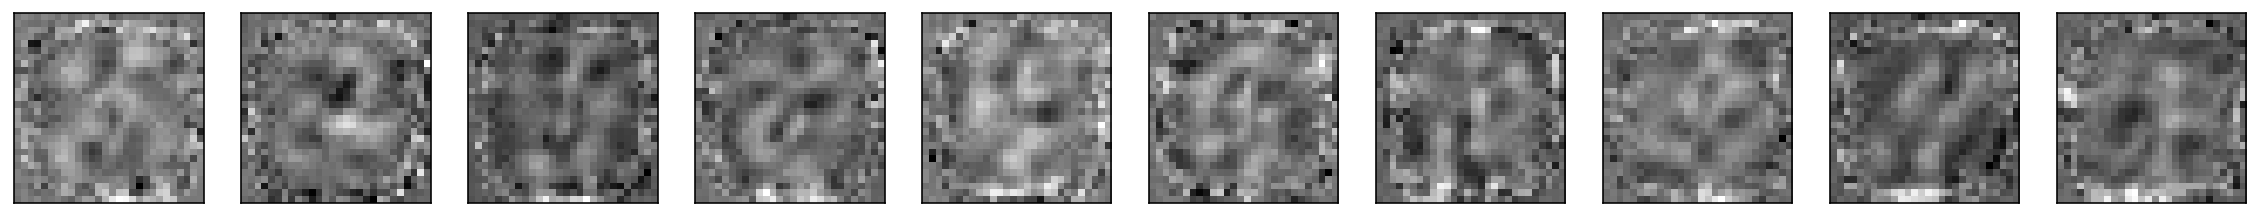

In [13]:

weights = autoencoder.get_weights()[0].T

n = 10
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(weights[i+20].reshape(28, 28))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

### Denoising Autoencoder

There is another way to force the autoencoder to learn useful features, which is adding random noise to its inputs and making it recover the original noise-free data. This way the autoencoder can’t simply copy the input to its output because the input also contains random noise. We are asking it to subtract the noise and produce the underlying meaningful data.

In [14]:
noise_factor = 0.4
x_train_noisy = x_train + noise_factor * np.random.normal(size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0.0, 1.0)
x_test_noisy = np.clip(x_test_noisy, 0.0, 1.0)


In [15]:
input_size = 784
hidden_size = 128
code_size = 32

input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_2 = Dense(hidden_size, activation='relu')(code)
output_img = Dense(input_size, activation='sigmoid')(hidden_2)

autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mean_squared_error',
                    metrics=['accuracy'])
autoencoder.fit(x_train_noisy, x_train, epochs=20)

Epoch 1/20
60000/60000 [==============================] - 7s 117us/step - loss: 0.0320 - acc: 0.0100
Epoch 2/20
60000/60000 [==============================] - 7s 116us/step - loss: 0.0203 - acc: 0.0123
Epoch 3/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.0184 - acc: 0.0128
Epoch 4/20
60000/60000 [==============================] - 7s 120us/step - loss: 0.0173 - acc: 0.0121
Epoch 5/20
60000/60000 [==============================] - 7s 121us/step - loss: 0.0165 - acc: 0.0120
Epoch 6/20
60000/60000 [==============================] - 7s 116us/step - loss: 0.0160 - acc: 0.0124
Epoch 7/20
60000/60000 [==============================] - 7s 111us/step - loss: 0.0156 - acc: 0.0124
Epoch 8/20
60000/60000 [==============================] - 7s 114us/step - loss: 0.0153 - acc: 0.0128
Epoch 9/20
60000/60000 [==============================] - 7s 117us/step - loss: 0.0150 - acc: 0.0125
Epoch 10/20
60000/60000 [==============================] - 7s 118us/step - loss: 0.0148 - a

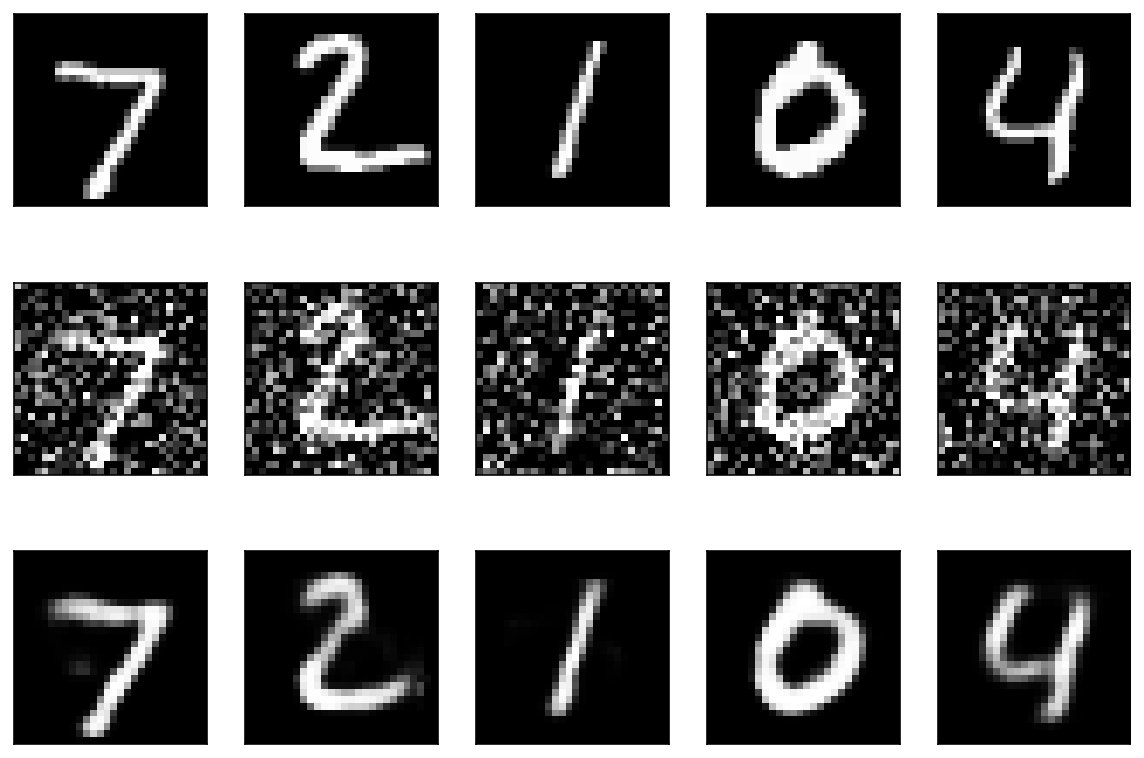

In [16]:

n = 5
plt.figure(figsize=(10, 7))

images = autoencoder.predict(x_test_noisy)

for i in range(n):
    # plot original image
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Original Images')

    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Noisy Input')
        
    # plot noisy image 
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(images[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == n/2:
        ax.set_title('Autoencoder Output')

### Sparse autoencoders

We can regularize the autoencoder by using a sparsity constraint such that only a fraction of the nodes would have nonzero values, called active nodes.
In particular, we add a penalty term to the loss function such that only a fraction of the nodes become active. This forces the autoencoder to represent each input as a combination of small number of nodes, and demands it to discover interesting structure in the data. This method works even if the code size is large, since only a small subset of the nodes will be active at any time.

In [21]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size,))
code = Dense(code_size, activation='relu')(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_standard = Model(input_img, output_img)
autoencoder_standard.compile(optimizer='adam', loss='mean_squared_error',
                    metrics=['accuracy'])
history_standard = autoencoder_standard.fit(x_train, x_train, epochs=20)

encoded_standard = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 5s 87us/step - loss: 0.0321 - acc: 0.0113
Epoch 2/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.0135 - acc: 0.0113
Epoch 3/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0112 - acc: 0.0112
Epoch 4/20
60000/60000 [==============================] - 5s 86us/step - loss: 0.0107 - acc: 0.0115
Epoch 5/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0105 - acc: 0.0118
Epoch 6/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0104 - acc: 0.0118
Epoch 7/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0103 - acc: 0.0119
Epoch 8/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0103 - acc: 0.0116
Epoch 9/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0102 - acc: 0.0123
Epoch 10/20
60000/60000 [==============================] - 5s 82us/step - loss: 0.0102 - acc: 0.0114

In [22]:
input_size = 784
code_size = 32

input_img = Input(shape=(input_size, ))
code = Dense(code_size, activation='relu',
             activity_regularizer=l1(10e-6))(input_img)
output_img = Dense(input_size, activation='sigmoid')(code)

autoencoder_regularized = Model(input_img, output_img)
autoencoder_regularized.compile(optimizer='adam',
                                loss='mean_squared_error',
                                metrics=['accuracy'])
history_regularized = autoencoder_regularized.fit(x_train, x_train, epochs=20)

encoded_regularized = Model(input_img, code)

Epoch 1/20
60000/60000 [==============================] - 5s 86us/step - loss: 0.0457 - acc: 0.0110
Epoch 2/20
60000/60000 [==============================] - 5s 79us/step - loss: 0.0292 - acc: 0.0114
Epoch 3/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0252 - acc: 0.0102
Epoch 4/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0234 - acc: 0.0104
Epoch 5/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0220 - acc: 0.0105
Epoch 6/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0212 - acc: 0.0105
Epoch 7/20
60000/60000 [==============================] - 5s 81us/step - loss: 0.0206 - acc: 0.0111
Epoch 8/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0201 - acc: 0.0109
Epoch 9/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0197 - acc: 0.0110
Epoch 10/20
60000/60000 [==============================] - 5s 80us/step - loss: 0.0194 - acc: 0.0110

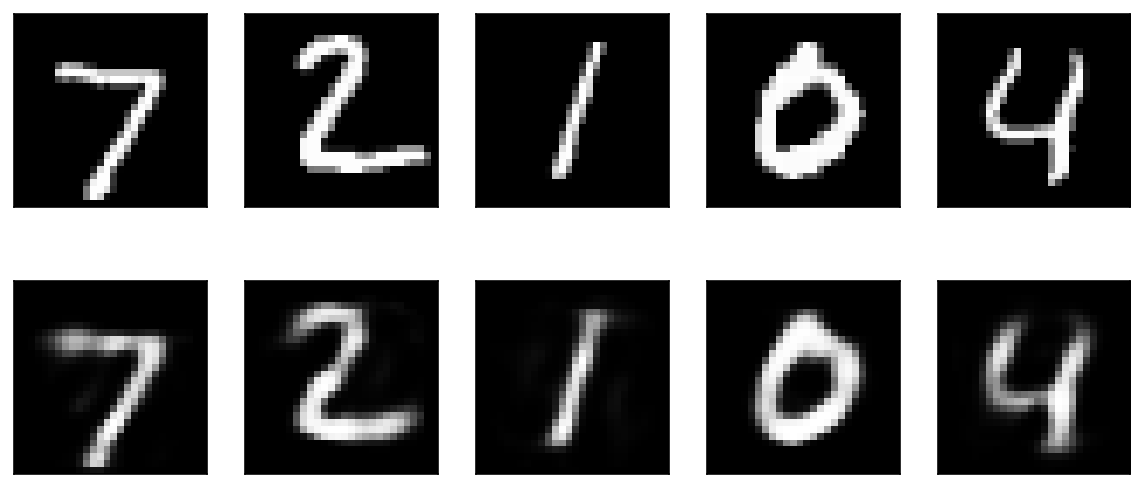

In [23]:
plot_autoencoder_outputs(autoencoder_regularized, 5, (28, 28))

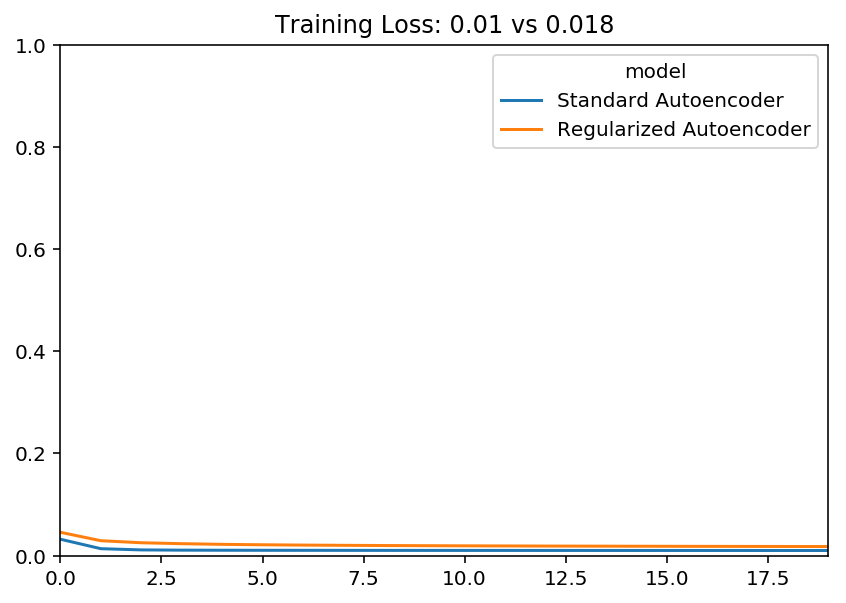

In [24]:
plot_compare_histories([history_standard, history_regularized],
                       ['Standard Autoencoder', 'Regularized Autoencoder'],
                       plot_accuracy=False)

In [25]:
autoencoder_standard.evaluate(x_test, x_test)


10000/10000 [==============================] - 0s 46us/step


[0.009680656798183918, 0.0106]

In [26]:
autoencoder_regularized.evaluate(x_test, x_test)


10000/10000 [==============================] - 1s 54us/step


[0.017419505047798156, 0.0123]

Let’s demonstrate the encodings generated by the regularized model are indeed sparse. 

In [27]:
print(encoded_standard.predict(x_test).mean())
print(encoded_regularized.predict(x_test).mean())

6.6855054
0.35229045


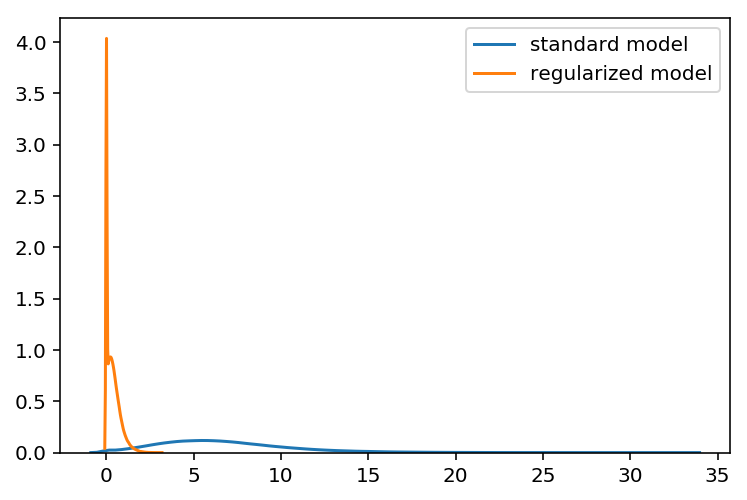

In [28]:
standard_scores = encoded_standard.predict(x_test).ravel()
regularized_scores = encoded_regularized.predict(x_test).ravel()
sns.distplot(standard_scores, hist=False, label='standard model')
sns.distplot(regularized_scores, hist=False, label='regularized model')

The mean for the standard model is 7.6 but for the regularized model it’s 0.9, a pretty big reduction. We can see that a large chunk of code values in the regularized model are indeed 0, which is what we wanted. The variance of the regularized model is also fairly low.

In [ ]:
# To see the encoded values 
encoded_regularized.predict(x_test)[1]

In [ ]:
import tensorflow as tf 
tf.test.is_built_with_cuda()